## Welcome to your first studio notebook! 
### This is a simple notebook to infer the parameters of a straight line model. 

It accompanies Chapter 1 of the book.
We'll continue building on it as part of your first homework assignment.

Copyright: Viviana Acquaviva (2023)

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

Modified by Julieta Gruszko (2025)

#### List the names your group members below:

Peter Chtcheprov, Henry Holland, Andrei Gogosha

In [38]:
# First, let's import the packages we'll use
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [39]:
# Here are some settings to make the plots look nicer
font = {'size'   : 14}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': False})
#matplotlib.rcParams['figure.dpi'] = 300

In this notebook, we generate some data that follow a linear relationship with some noise, and we use a grid search to find the best fit model, with and without considering the uncertainties. Then, we'll try some machine learning models on the same data.

These data could represent any measurements where a linear relationship is a good model for the underlying physics. Let's imagine them as measurements taken of distance traveled at difference points in time by a cart on a track moving at constant velocity.

In [40]:
np.random.seed(16) #why are we fixing the seed?

x = np.arange(10) # returns a numpy array containing integers 0 to 9

y = 2*x + 5 + np.random.randn(10) #generate some data with random gaussian scatter and add it to 2*x+5. 

### Two questions:
#### 1. What is the mean and standard deviation ($\sigma$) of the Gaussian noise being added to the y values? (Hint: VS Code should give you information about a function when you hover your mouse over it. What is randn(10) doing?)
#### 2. If the x values are times in s and the y values are distances in m, what is the "true" velocity of the cart?

Put your answers in the cell below:

1. The standard deviation is 1 and the mean is 0.
2. Based on 2x, the velocity would be 2 m/s

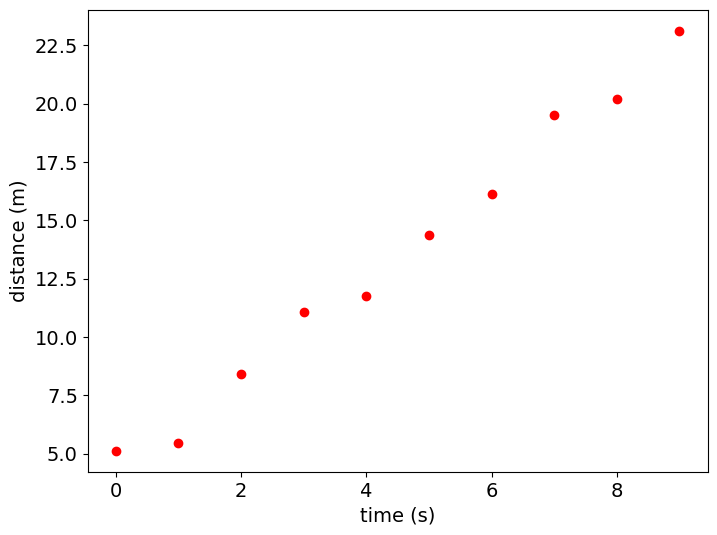

In [41]:
plt.figure(figsize=(8,6)) #
plt.scatter(x,y, c = 'red')
plt.xlabel('time (s)')
plt.ylabel('distance (m)');

In [42]:
y = np.round(y,1) #match the book
print(y)

[ 5.1  5.5  8.4 11.1 11.8 14.4 16.1 19.5 20.2 23.1]


Let's generate a grid of slopes and intercepts, after deciding a reasonable range by looking at the graph. 

In [43]:
slopes = np.linspace(1,3,101) # asks numpy to give us an array of 101 values from 1 to 3. Choosing 101 gives us nicer-looking numbers

intercepts = np.linspace(4,6,101) 

In [44]:
slopes #just checking

array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
       1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42,
       1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64,
       1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86,
       1.88, 1.9 , 1.92, 1.94, 1.96, 1.98, 2.  , 2.02, 2.04, 2.06, 2.08,
       2.1 , 2.12, 2.14, 2.16, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 ,
       2.32, 2.34, 2.36, 2.38, 2.4 , 2.42, 2.44, 2.46, 2.48, 2.5 , 2.52,
       2.54, 2.56, 2.58, 2.6 , 2.62, 2.64, 2.66, 2.68, 2.7 , 2.72, 2.74,
       2.76, 2.78, 2.8 , 2.82, 2.84, 2.86, 2.88, 2.9 , 2.92, 2.94, 2.96,
       2.98, 3.  ])

In [10]:
intercepts

array([4.  , 4.02, 4.04, 4.06, 4.08, 4.1 , 4.12, 4.14, 4.16, 4.18, 4.2 ,
       4.22, 4.24, 4.26, 4.28, 4.3 , 4.32, 4.34, 4.36, 4.38, 4.4 , 4.42,
       4.44, 4.46, 4.48, 4.5 , 4.52, 4.54, 4.56, 4.58, 4.6 , 4.62, 4.64,
       4.66, 4.68, 4.7 , 4.72, 4.74, 4.76, 4.78, 4.8 , 4.82, 4.84, 4.86,
       4.88, 4.9 , 4.92, 4.94, 4.96, 4.98, 5.  , 5.02, 5.04, 5.06, 5.08,
       5.1 , 5.12, 5.14, 5.16, 5.18, 5.2 , 5.22, 5.24, 5.26, 5.28, 5.3 ,
       5.32, 5.34, 5.36, 5.38, 5.4 , 5.42, 5.44, 5.46, 5.48, 5.5 , 5.52,
       5.54, 5.56, 5.58, 5.6 , 5.62, 5.64, 5.66, 5.68, 5.7 , 5.72, 5.74,
       5.76, 5.78, 5.8 , 5.82, 5.84, 5.86, 5.88, 5.9 , 5.92, 5.94, 5.96,
       5.98, 6.  ])

#### Note: these are already > 10000 models (curse of dimensionality!)

For convenience, we can define two functions. The first implements our model (a straight line) and the second one is the sum of squared errors that we can use to evaluate each slope, intercept pair (ignoring uncertainties for now):
$$ \Sigma_i \Delta y_i^2 = \Sigma_i (y_i - \bar{y_i})^2 = \Sigma_i (y_i - (m x_i+b))^2 $$

where the index $i$ is over the data points, $y_i$ is the distance data, and $\bar{y_i}$ is the modeled distance at time $x_i$.

In [45]:
def model(x,m,b):
    return m*x + b

def se(x,m,b,yobs):
    return np.sum((yobs - model(x,m,b))**2)

We can calculate the squared error for each value and save it in the "square_errs" array.

In [46]:
square_errs = np.zeros((101,101)) #Initialization

For loops are less "pythonic" (and usually less efficient), but often easier to read and understand. Sometimes a nice way to work is to start by writing the loop version, and then going back and replacing those lines with more-efficient versions once you have your basic algorithm in place. 

In [47]:
for i, m in enumerate(slopes):
    for j,b in enumerate(intercepts):
        square_errs[i,j] = se(x,m,b,y)

We can also do this with a one-liner by using list comprehension:

In [48]:
square_errs = np.array([[se(x,m,b,y) for b in intercepts] for m in slopes]) 

In [50]:
square_errs.shape #check that the array has been built properly

(101, 101)

In [51]:
square_errs

array([[346.34 , 344.336, 342.34 , ..., 187.972, 186.752, 185.54 ],
       [333.958, 331.99 , 330.03 , ..., 179.118, 177.934, 176.758],
       [321.804, 319.872, 317.948, ..., 170.492, 169.344, 168.204],
       ...,
       [216.588, 218.112, 219.644, ..., 403.964, 406.272, 408.588],
       [226.55 , 228.11 , 229.678, ..., 417.454, 419.798, 422.15 ],
       [236.74 , 238.336, 239.94 , ..., 431.172, 433.552, 435.94 ]],
      shape=(101, 101))

Note that this generates an array where the first index refers to slope and the second index refers to intercept.


#### Let's figure out which model is the best fit (lowest Squared Error).

In [52]:
np.argmin(square_errs) #index of min; however this corresponds to flattened array

np.int64(5269)

In [53]:
indices = np.unravel_index(square_errs.argmin(), square_errs.shape) #indices of minimum value as a (row, col) pair

print(indices)

(np.int64(52), np.int64(17))


We can now derive the slope and intercept for the best-fitting model.

In [54]:
bestm, bestb = slopes[indices[0]],intercepts[indices[1]]

In [55]:
bestm, bestb 

(np.float64(2.04), np.float64(4.34))

### Question: How do the best-fit slope and y-intercept compare to the original ones?
When you're asked something like this, it's good to make it quantitative! An easy way to do that is to give the % disagreement.

slope: (2.04 - 2) /2 = 2 %
intercept: (4.34 - 5) / 5 = 13.2%

Finally, we plot the best fit model against the data.

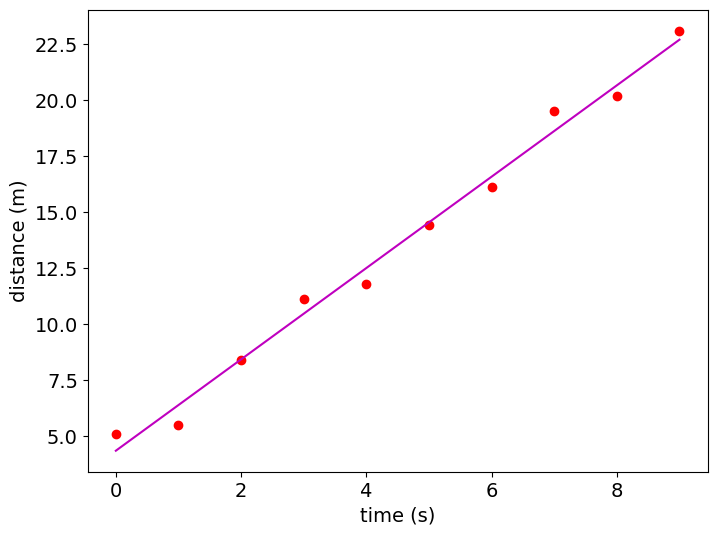

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(x,y, c = 'red') 
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.plot(x, bestm * x + bestb, c = 'm'); 

#### What if there are varying distance measurement uncertainties on each data point? Let's see how our fit changes.

First let's generate some error bars for the points.

In [57]:
np.random.seed(10)

dy = np.random.randn(10)*np.sqrt(2) #these are the uncertainties; sign doesn't matter.

In [58]:
dy

array([ 1.88314769,  1.01155723, -2.18552605, -0.01185655,  0.87870176,
       -1.01835477,  0.37549009,  0.1535108 ,  0.006069  , -0.24692199])

We want to consider the uncertainties by giving more weight to data points with a lower uncertainties. This can be achieved by modifying the squared error function with an inverse weight of the uncertainties. The error function becomes the chi squared:

$$\chi^2 = \Sigma_i \frac{(y_i - \bar{y_i})^2}{\epsilon_i^2}$$

where $i$ runs over all the data points, $y_i$ is the observed value, $\bar{y_i}$ is the expected value of the model at that point, and $\epsilon_i$ is the uncertainty of the data point.



#### Your turn:
Write a function that returns the $\chi^2$ value for an array of observed points with associated errors, given the parameters of the linear model $m$, and $b$.

In [59]:
def chi2(x,m,b,yobs,err):
    return np.sum(((yobs - (m*x+b)) / err) ** 2)

We can now generate the array of the modified evaluation function, and find the indices of its minimum like we did above.

In [60]:
allchi2 = np.array([[chi2(x,m,b,y,dy) for b in intercepts] for m in slopes]) 

In [61]:
print(allchi2.argmin()) #index of min; however this corresponds to flattened array

indices = np.unravel_index(allchi2.argmin(), allchi2.shape) #indices of minimum value as a (row, col) pair

4223


### Your turn again: as above, get the slope and y intercept of the best model and compare them to the results without uncertainties.

In [62]:
#Derive the slope and intercept for best model

bestm_werr, bestb_werr = slopes[indices[0]],intercepts[indices[1]]

In [63]:
bestm_werr, bestb_werr

(np.float64(1.82), np.float64(5.640000000000001))

We can plot the data (with uncertainties) and the new best fit line.

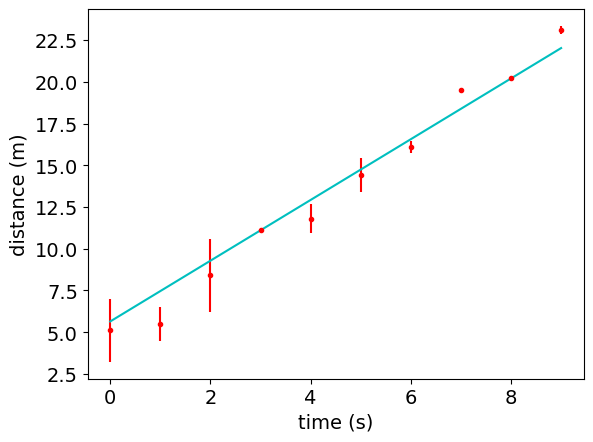

In [64]:
plt.errorbar(x,y, np.abs(dy), marker = 'o', markersize = 3, c = 'red', linestyle = ' ')
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.plot(x, bestb_werr + bestm_werr * x, c = 'c');

We can compare the two lines:

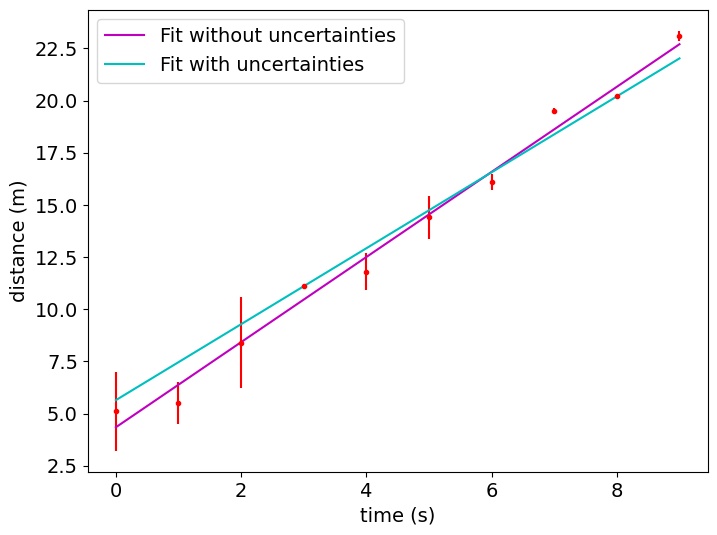

In [65]:
plt.figure(figsize=(8,6))

plt.errorbar(x,y, np.abs(dy), marker = 'o', markersize = 3, c = 'red', linestyle = ' ')

plt.plot(x, bestb + bestm * x, c = 'm', label = 'Fit without uncertainties')

plt.plot(x, bestb_werr + bestm_werr * x, c = 'c', label = 'Fit with uncertainties')

plt.xlabel('time (s)')

plt.ylabel('distance (m)')

plt.legend();


#### Question: 
Does the change make sense? Explain what you're seeing (and why). 

Yes the fit with uncertainites only misses 4 points while the fit without uncertainities misses 5 points. The chi squared test prioritizes being within the error bars.

### Next, we'll see how using machine learning to solve this problem differs from using a "traditional" inference approach. 

We'll use the same data as before, and try two models that we'll study in depth in the coming weeks: a Decision Tree Regressor and Linear Regression. To use them, we have to first import the models from scikit-learn. We'll also use sklearn's tools to split the data into train and test sets.

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

We'll split our data into train/test sets with a 70/30 split. In this case, that means 3 test points.

In [67]:
np.random.seed(10) #fix for reproducibility
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=3) #create train/test split

We can take a look at what points are in each set:

In [68]:
X_train, y_train

(array([6, 3, 1, 0, 7, 4, 9]),
 array([16.1, 11.1,  5.5,  5.1, 19.5, 11.8, 23.1]))

In [69]:
X_test

array([8, 2, 5])

The output of the test set is hidden: that's what we're trying to reproduce with our ML models.

We'll make a model object for each of our two models, each using the default parameters from sklearn

In [71]:
treemodel = DecisionTreeRegressor() # default params
regmodel = LinearRegression() # default params

Let's try training our first model! scikit-learn's $\texttt{fit}$ method does the training. We need to give it our training data (both the x and y values).

In [72]:
treemodel.fit(X_train, y_train)
regmodel.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[6. 3. 1. 0. 7. 4. 9.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Whoops, that didn't work! Luckily the error message is quite informative, and even tells us how to fix the problem. 

#### Your turn! Fix the error and train the two models:

In [73]:
# your code to train the decision tree model here
X_train = X_train.reshape(-1, 1)
treemodel.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [74]:
# your code to train the linear regression model here
regmodel.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Notice that the print out associated with the model object returned here is quite helpful! It tells us the settings used to train the model, and you can mouse over the "i" to see that the model has been fitted. Clicking the "?" takes you to the documentation page for the model.

Now, let's use our trained models to predict the y values for the test set:

In [75]:
y_pred_tree = treemodel.predict(X_test)
y_pred_reg = regmodel.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[8. 2. 5.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Same error as before! By now, you should be a pro at fixing it.
### Your turn:

In [76]:
X_test = X_test.reshape(-1, 1)
y_pred_tree = treemodel.predict(X_test)
y_pred_reg = regmodel.predict(X_test)

Let's take a look at the results. 

In [77]:
print(y_test, y_pred_reg, y_pred_tree) #True/predicted by LR and DT respectively

[20.2  8.4 14.4] [20.89279279  8.41981982 14.65630631] [19.5  5.5 11.8]


Let's calculate the mean squared error with each model.

In [78]:
np.mean((y_test-y_pred_reg)**2)

np.float64(0.18201586721857252)

In [79]:
np.mean((y_test-y_pred_tree)**2)

np.float64(5.22)

Ultimately, our goal in building a model is often to use it to make predictions. Let's use our two linear fits and our two ML models to predict what the cart's distance will be at t = 12 s. 

I'll get you started with two of the four values:

In [80]:
linpred = bestm * 12 + bestb
treepred = treemodel.predict(np.array(12).reshape(-1, 1))

### Your turn: 
Find the prediction of the linear fit that takes uncertainties into account and of the linear regression model.

In [82]:
bestm_unc, bestb_unc = np.polyfit(x, y, deg=1, w=1/dy)
linuncpred = bestm_unc * 12 + bestb_unc
regpred = regmodel.predict(np.array(12).reshape(-1, 1))

Let's plot the results, including the predictions.

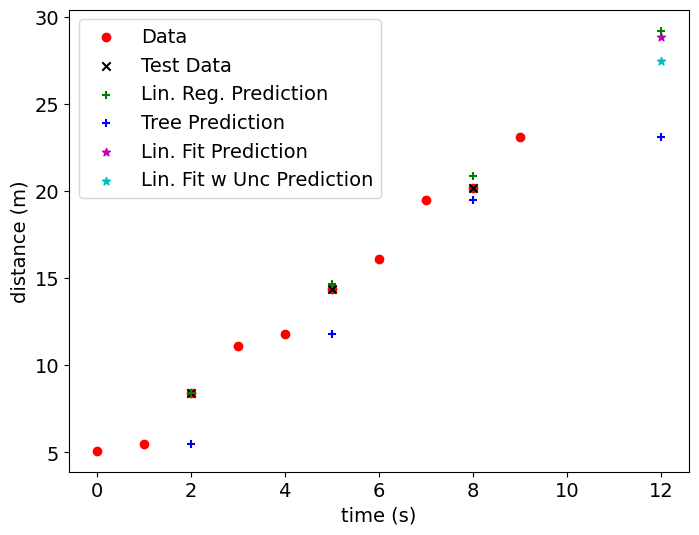

In [83]:
plt.figure(figsize=(8,6))
plt.scatter(x,y, c = 'red', label = "Data")
plt.xlabel('time (s)')
plt.ylabel('distance (m)')
plt.scatter(X_test, y_test, marker="x", label="Test Data", c="black")
plt.scatter(X_test, y_pred_reg, marker="+", c="green", label="Lin. Reg. Prediction")
plt.scatter(X_test, y_pred_tree, marker="+", c="blue", label="Tree Prediction")
plt.scatter(12, linpred, marker="*", c="m", label="Lin. Fit Prediction")
plt.scatter(12, linuncpred, marker="*", c="c", label="Lin. Fit w Unc Prediction")
plt.scatter(12, treepred, marker="+", c="blue")
plt.scatter(12, regpred, marker="+", c="green")
plt.legend()

### Questions (answer all 4 in the markdown cell below):
1. Which of the two ML models is performing better, in this case? Back up your assessment with at least two pieces of evidence.

2. What are some advantages and disadvantages of a machine learning based-approach, in the context of this problem? Hint: think about the different things we might be trying to achieve with this data - e.g. extracting the velocity and starting position of the cart, predicting future motion (extrapolation), figuring out what the cart was doing between measurements (interpolation). 

3. Did the ML models allow us to take the uncertainty of the measurements into account?

4. We'll see in future weeks that the linear regression model we used should be equivalent to a linear fit. In this case, though, it gave us a different prediction for the point at t = 12 than either of our linear fits. Give 1 reason why that might be the case.


1. The linear regression prediction follows the general straight line trend of the data much more closely, while the tree model jumps around between points and doesn’t capture the linear motion. At higher times, the tree prediction produces deviations compared to the smooth trend of the real data, unlike the the linear regression prediction.

2. 
Advantages:
- ML models like trees can fit very complex or nonlinear relationships if the data had them.
- Can interpolate well between points in cases with irregular patterns.

Disadvantages:
- Less interpretable: It’s harder to extract meaningful physical quantities (like velocity or initial position) from a tree model compared to a linear regression fit.

3. No, neither the tree nor the linear regression model here incorporated measurement uncertainties. They simply fit the given data points without weighting them by error bars. Only the linear fit with uncertainty explicitly includes uncertainties in its predictions.

4. The difference happened because the regression line is chosen to best fit all the data points we had, not to perfectly match a continuous line through them, so when we extend it to 12 seconds the prediction can be a little different.

### Acknowledgement statement: every assignment you submit will include an acknowledgement statement crediting the resources (human or otherwise) that you relied on for your work. In this case, your group mates are all already credited, but if you used any other resources, credit them here.

We gratefully acknowledge...

### That's it for this studio! Upload your completed notebook to Gradescope to submit it.